In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as sp
from sklearn.model_selection import GroupShuffleSplit
import sreftml
from tensorflow import keras

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Make demodata

In [2]:
df, params = sreftml.make_demodata.data_synthesis(
    rng_seed=42,
    n_biomarker_total=10,
    n_biomarker_noise=2,
    n_covariate_total=2,
    n_covariate_noise=0,
    n_subject=6000,
    onset_duration=10,
    observation_period=5
)
df.head()

ID  TIME  offsetT_true    FUTIME  event_time  event  Biomarker1  \
0   1   0.0       7.73956  2.847083   10.586644      1         NaN   
1   1   1.0       7.73956  2.847083   10.586644      1    0.542001   
2   1   2.0       7.73956  2.847083   10.586644      1    0.620019   
3   1   3.0       7.73956  2.847083   10.586644      1    0.453675   
4   1   4.0       7.73956  2.847083   10.586644      1         NaN   

   Biomarker2  Biomarker3  Biomarker4  Biomarker5  Biomarker6  Biomarker7  \
0         NaN    0.719721    0.996006         NaN    0.040587         NaN   
1    0.058724         NaN    0.998114    0.015227    0.031955         NaN   
2    0.061465    0.513710    0.999436         NaN    0.032329    0.566683   
3         NaN         NaN         NaN         NaN    0.010331    0.549069   
4    0.026927    0.224250    0.999822         NaN         NaN    0.453093   

   Biomarker8  Biomarker9  Biomarker10  Covariate1  Covariate2  
0         NaN         NaN          NaN           0           1  
1    0.748792    0.434823          NaN           0           1  
2    0.880814         NaN     0.368690           0           1  
3         NaN         NaN     0.345003           0           1  
4         NaN    0.470497     0.357088           0           1

# Pre-process

In [3]:
((train_idx, test_idx),) = GroupShuffleSplit(
    1, test_size=1000, random_state=42
).split(X=df, groups=df.ID)

df_train = df.iloc[train_idx]
df_test = df.iloc[test_idx]

In [6]:
name_biomarkers = ["Biomarker" + str(i + 1) for i in range(10)]
name_covariates = ["Covariate" + str(i + 1) for i in range(2)]

x, cov, m, y = sreftml.utilities.split_data_for_sreftml(
    df_train, name_biomarkers, name_covariates, isMixedlm=False
)

scaler_m = sp.StandardScaler()
scaler_y = sp.StandardScaler()
scaler_cov = sp.StandardScaler()

x_scaled = x.values.reshape(-1, 1)
cov_scaled = scaler_cov.fit_transform(cov.values)
m_scaled = scaler_m.fit_transform(m.values)
y_scaled = scaler_y.fit_transform(y.values)

Missing value imputation was performed for some features.


In [5]:
x_test, cov_test, m_test, y_test = sreftml.utilities.split_data_for_sreftml(
    df_test, name_biomarkers, name_covariates, isMixedlm=False
)

x_scaled_test = x_test.values.reshape(-1, 1)
cov_scaled_test = scaler_cov.transform(cov_test.values)
m_scaled_test = scaler_m.transform(m_test.values)
y_scaled_test = scaler_y.transform(y_test.values)

Missing value imputation was performed for some features.


# Setting callbacks

In [7]:
class Logger(keras.callbacks.Callback):
    def set_params(self, params):
        self.epochs = params["epochs"]

    def on_epoch_end(self, epoch, logs={}):
        self.last_epoch = epoch
        unit = [1, 10, 100][np.digitize(epoch, [10, 100])]
        if (epoch + 1) % unit == 0:
            self.__print(epoch, logs)

    def on_train_end(self, logs={}):
        self.__print(self.last_epoch, logs)

    def __print(self, epoch, logs={}):
        txt = " - ".join([f"{k}: {v:9.3f}" for k, v in logs.items()])
        print(f"Epoch {epoch + 1:5d}/{self.epochs} - {txt}")

earlystop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="min",
    min_delta=0.000,
    cooldown=0,
    min_lr=0,
)

callbacks = [Logger(), earlystop, reduce_lr]

# Execute SReFT-ML

In [8]:
((train_idx, vali_idx),) = GroupShuffleSplit(
    1, test_size=0.1, random_state=42
).split(X=df_train, groups=df_train.ID)

sreft = sreftml.sreftml_model.SReFT(
    output_dim=len(name_biomarkers),
    latent_dim_model_1=m_scaled.shape[1],
    latent_dim_model_y=y_scaled.shape[1],
    activation_model_1_mid="softplus",
    activation_model_1_out="softplus",
    activation_model_y_mid="tanh",
    random_state=42,
)
sreft.compile(optimizer=keras.optimizers.Adam(1e-3))
sreft.fit(
    (
        x_scaled[train_idx, :],
        cov_scaled[train_idx, :],
        m_scaled[train_idx, :],
        y_scaled[train_idx, :],
    ),
    y_scaled[train_idx, :],
    batch_size=sum(train_idx),
    validation_data=(
        (
            x_scaled[vali_idx, :],
            cov_scaled[vali_idx, :],
            m_scaled[vali_idx, :],
            y_scaled[vali_idx, :],
        ),
        y_scaled[vali_idx, :],
    ),
    epochs=9999,
    verbose=0,
    callbacks=callbacks,
)

Epoch     1/9999 - loss:    11.226 - val_loss:    10.929
Epoch     2/9999 - loss:    11.146 - val_loss:    10.854
Epoch     3/9999 - loss:    11.068 - val_loss:    10.780
Epoch     4/9999 - loss:    10.991 - val_loss:    10.708
Epoch     5/9999 - loss:    10.915 - val_loss:    10.637
Epoch     6/9999 - loss:    10.841 - val_loss:    10.567
Epoch     7/9999 - loss:    10.768 - val_loss:    10.498
Epoch     8/9999 - loss:    10.696 - val_loss:    10.430
Epoch     9/9999 - loss:    10.626 - val_loss:    10.364
Epoch    10/9999 - loss:    10.557 - val_loss:    10.299
Epoch    20/9999 - loss:     9.929 - val_loss:     9.710
Epoch    30/9999 - loss:     9.403 - val_loss:     9.218
Epoch    40/9999 - loss:     8.956 - val_loss:     8.799
Epoch    50/9999 - loss:     8.571 - val_loss:     8.438
Epoch    60/9999 - loss:     8.234 - val_loss:     8.121
Epoch    70/9999 - loss:     7.935 - val_loss:     7.839
Epoch    80/9999 - loss:     7.669 - val_loss:     7.587
Epoch    90/9999 - loss:     7.

# Post-process

In [9]:
df_test = sreftml.utilities.calculate_offsetT_prediction(
    sreft, df_test, (x_scaled_test, cov_scaled_test, m_scaled_test, y_scaled_test), scaler_y, name_biomarkers
)

# Plot Results
We offer various plot options. For details, please refer to [our GitHub pages](https://ryotajin.github.io/sreft-ml/).

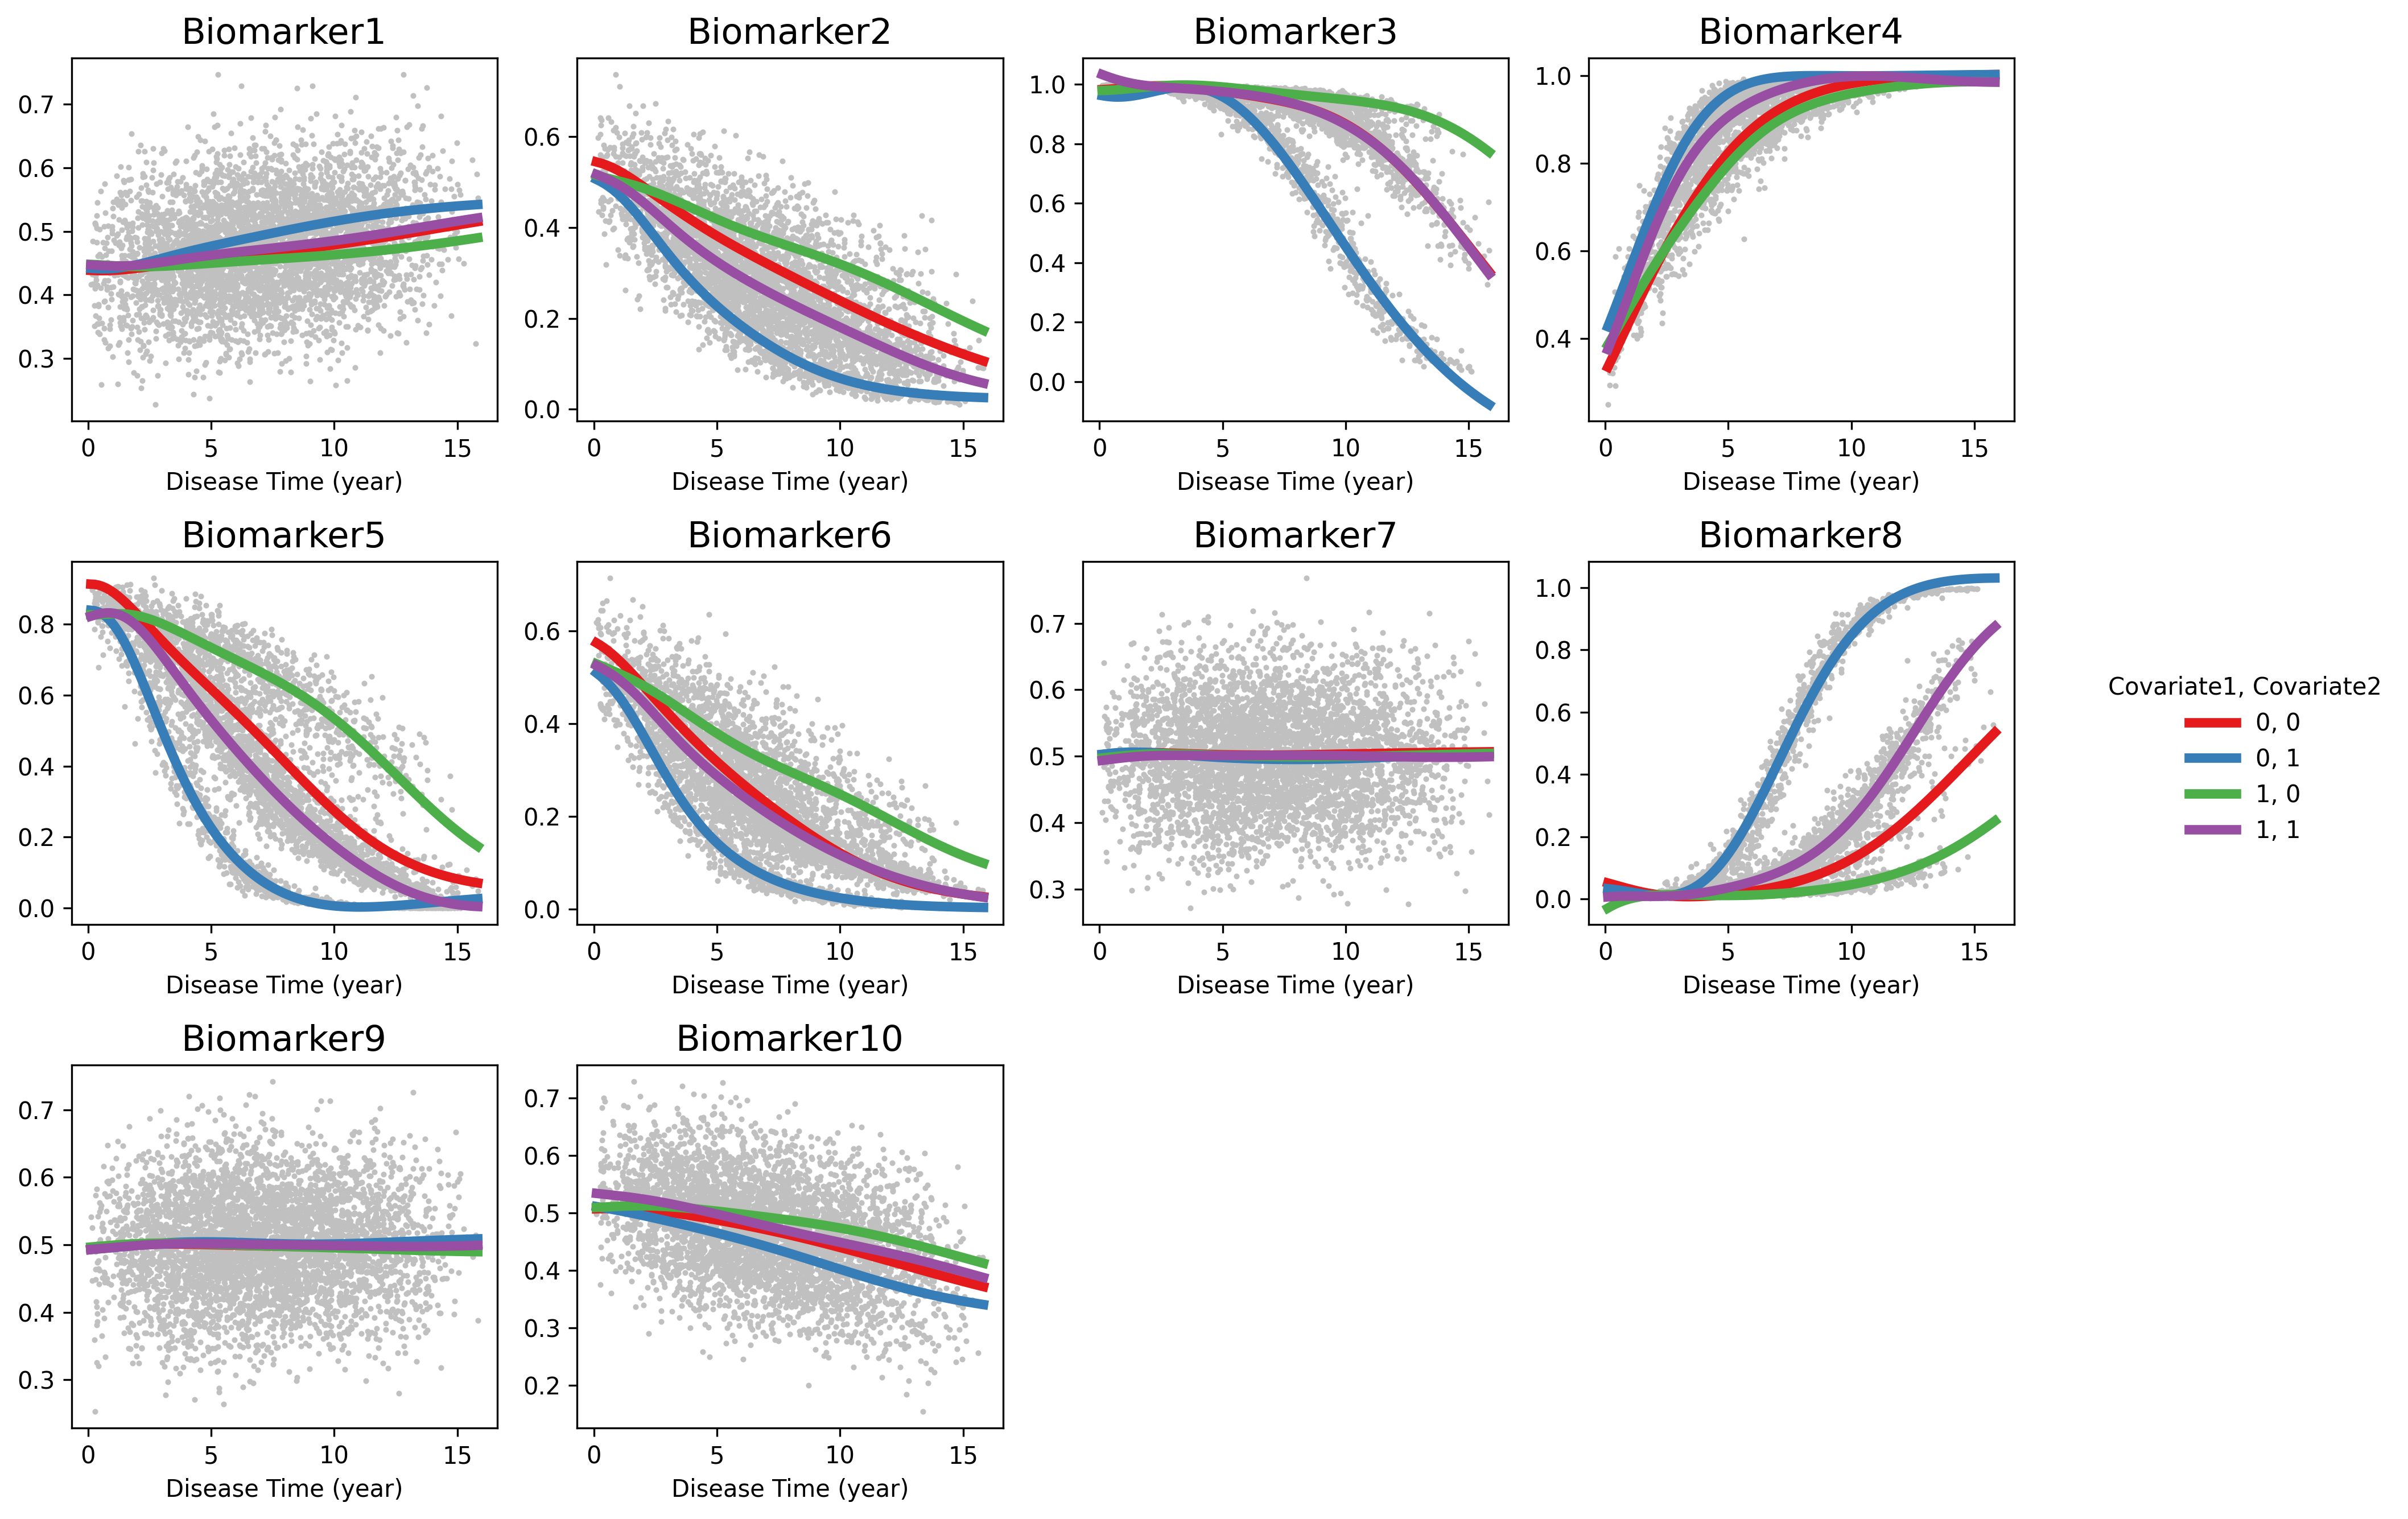

In [11]:
prediction_plot = sreftml.plots.prediction_plot(
    sreft,
    df_test,
    name_biomarkers,
    name_covariates,
    scaler_y,
    scaler_cov,
)

# Survival analysis

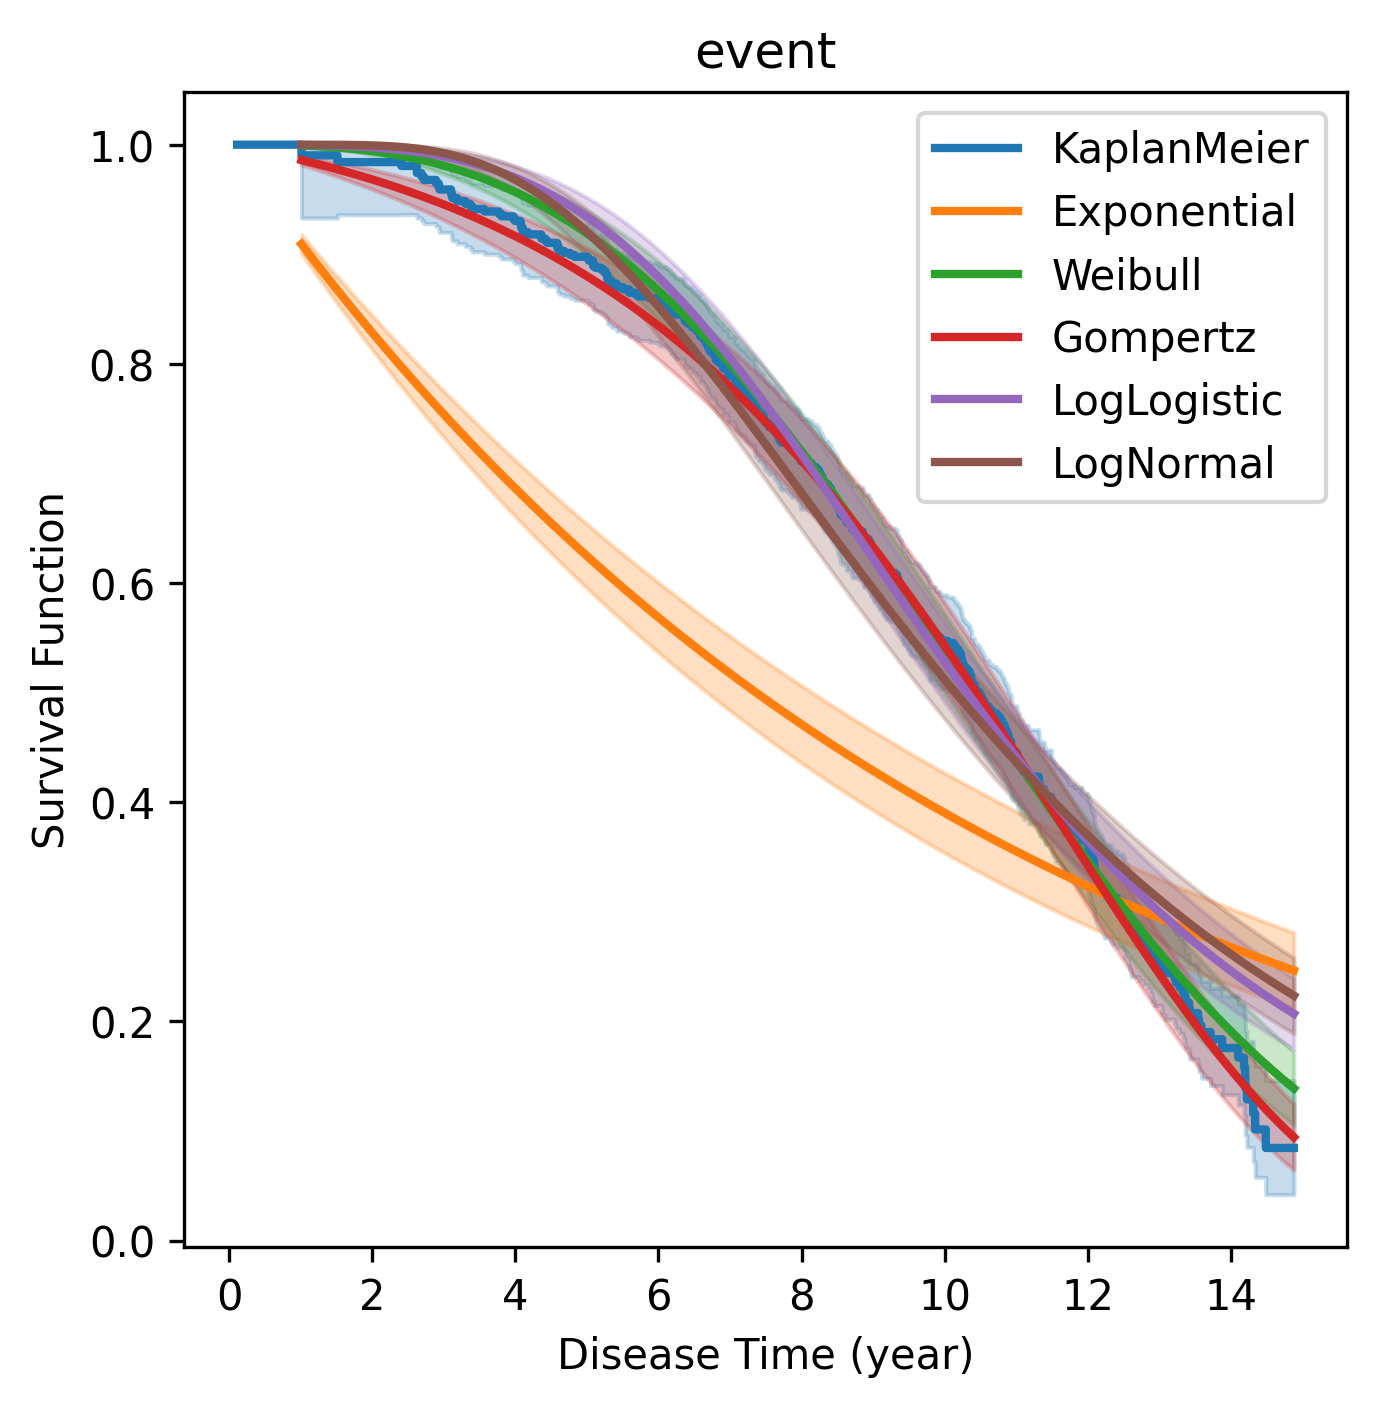

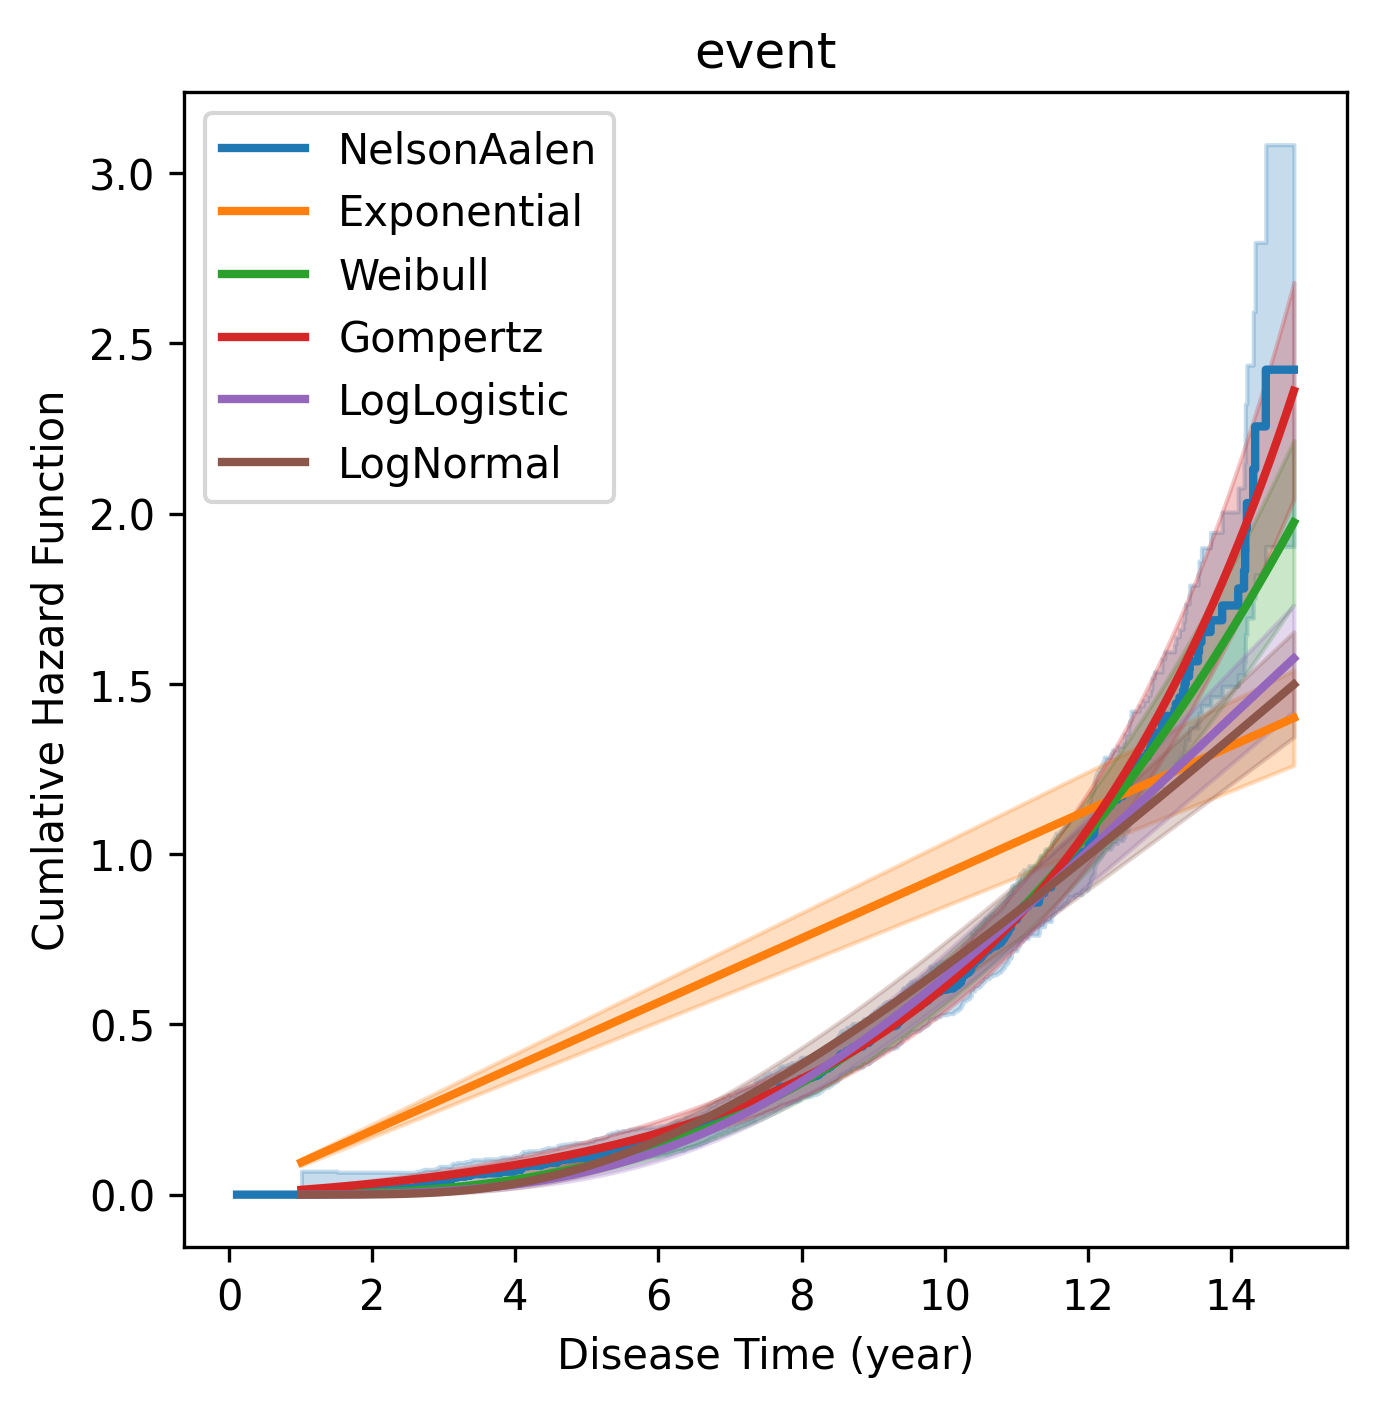

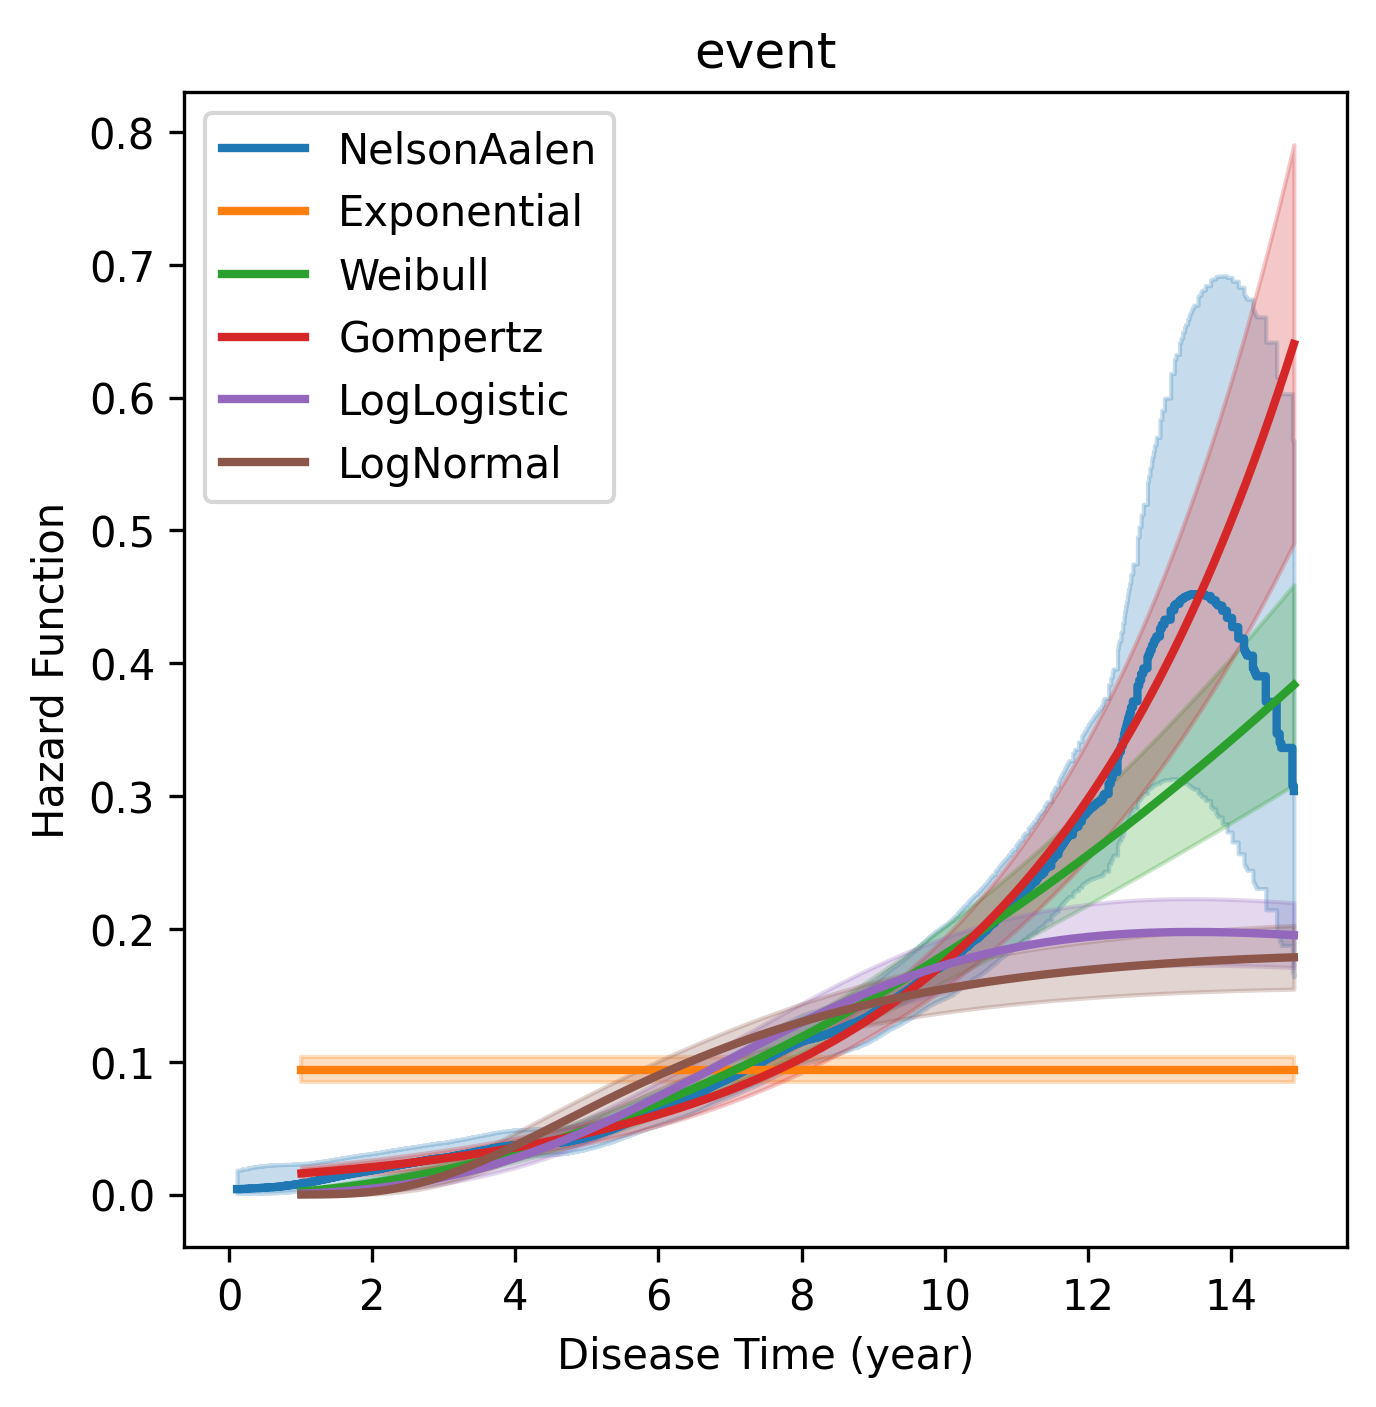

In [12]:
fit_model = sreftml.utilities.survival_analysis(
    df_test, surv_time="FUTIME", event="event", useOffsetT=True
)

surv_plot, cumhaz_plot, haz_plot = sreftml.plots.surv_analysis_plot(
    fit_model,
    ci_show=True,
    only_best=False,
)

# Compare with answer
These contents are only available in simulation.

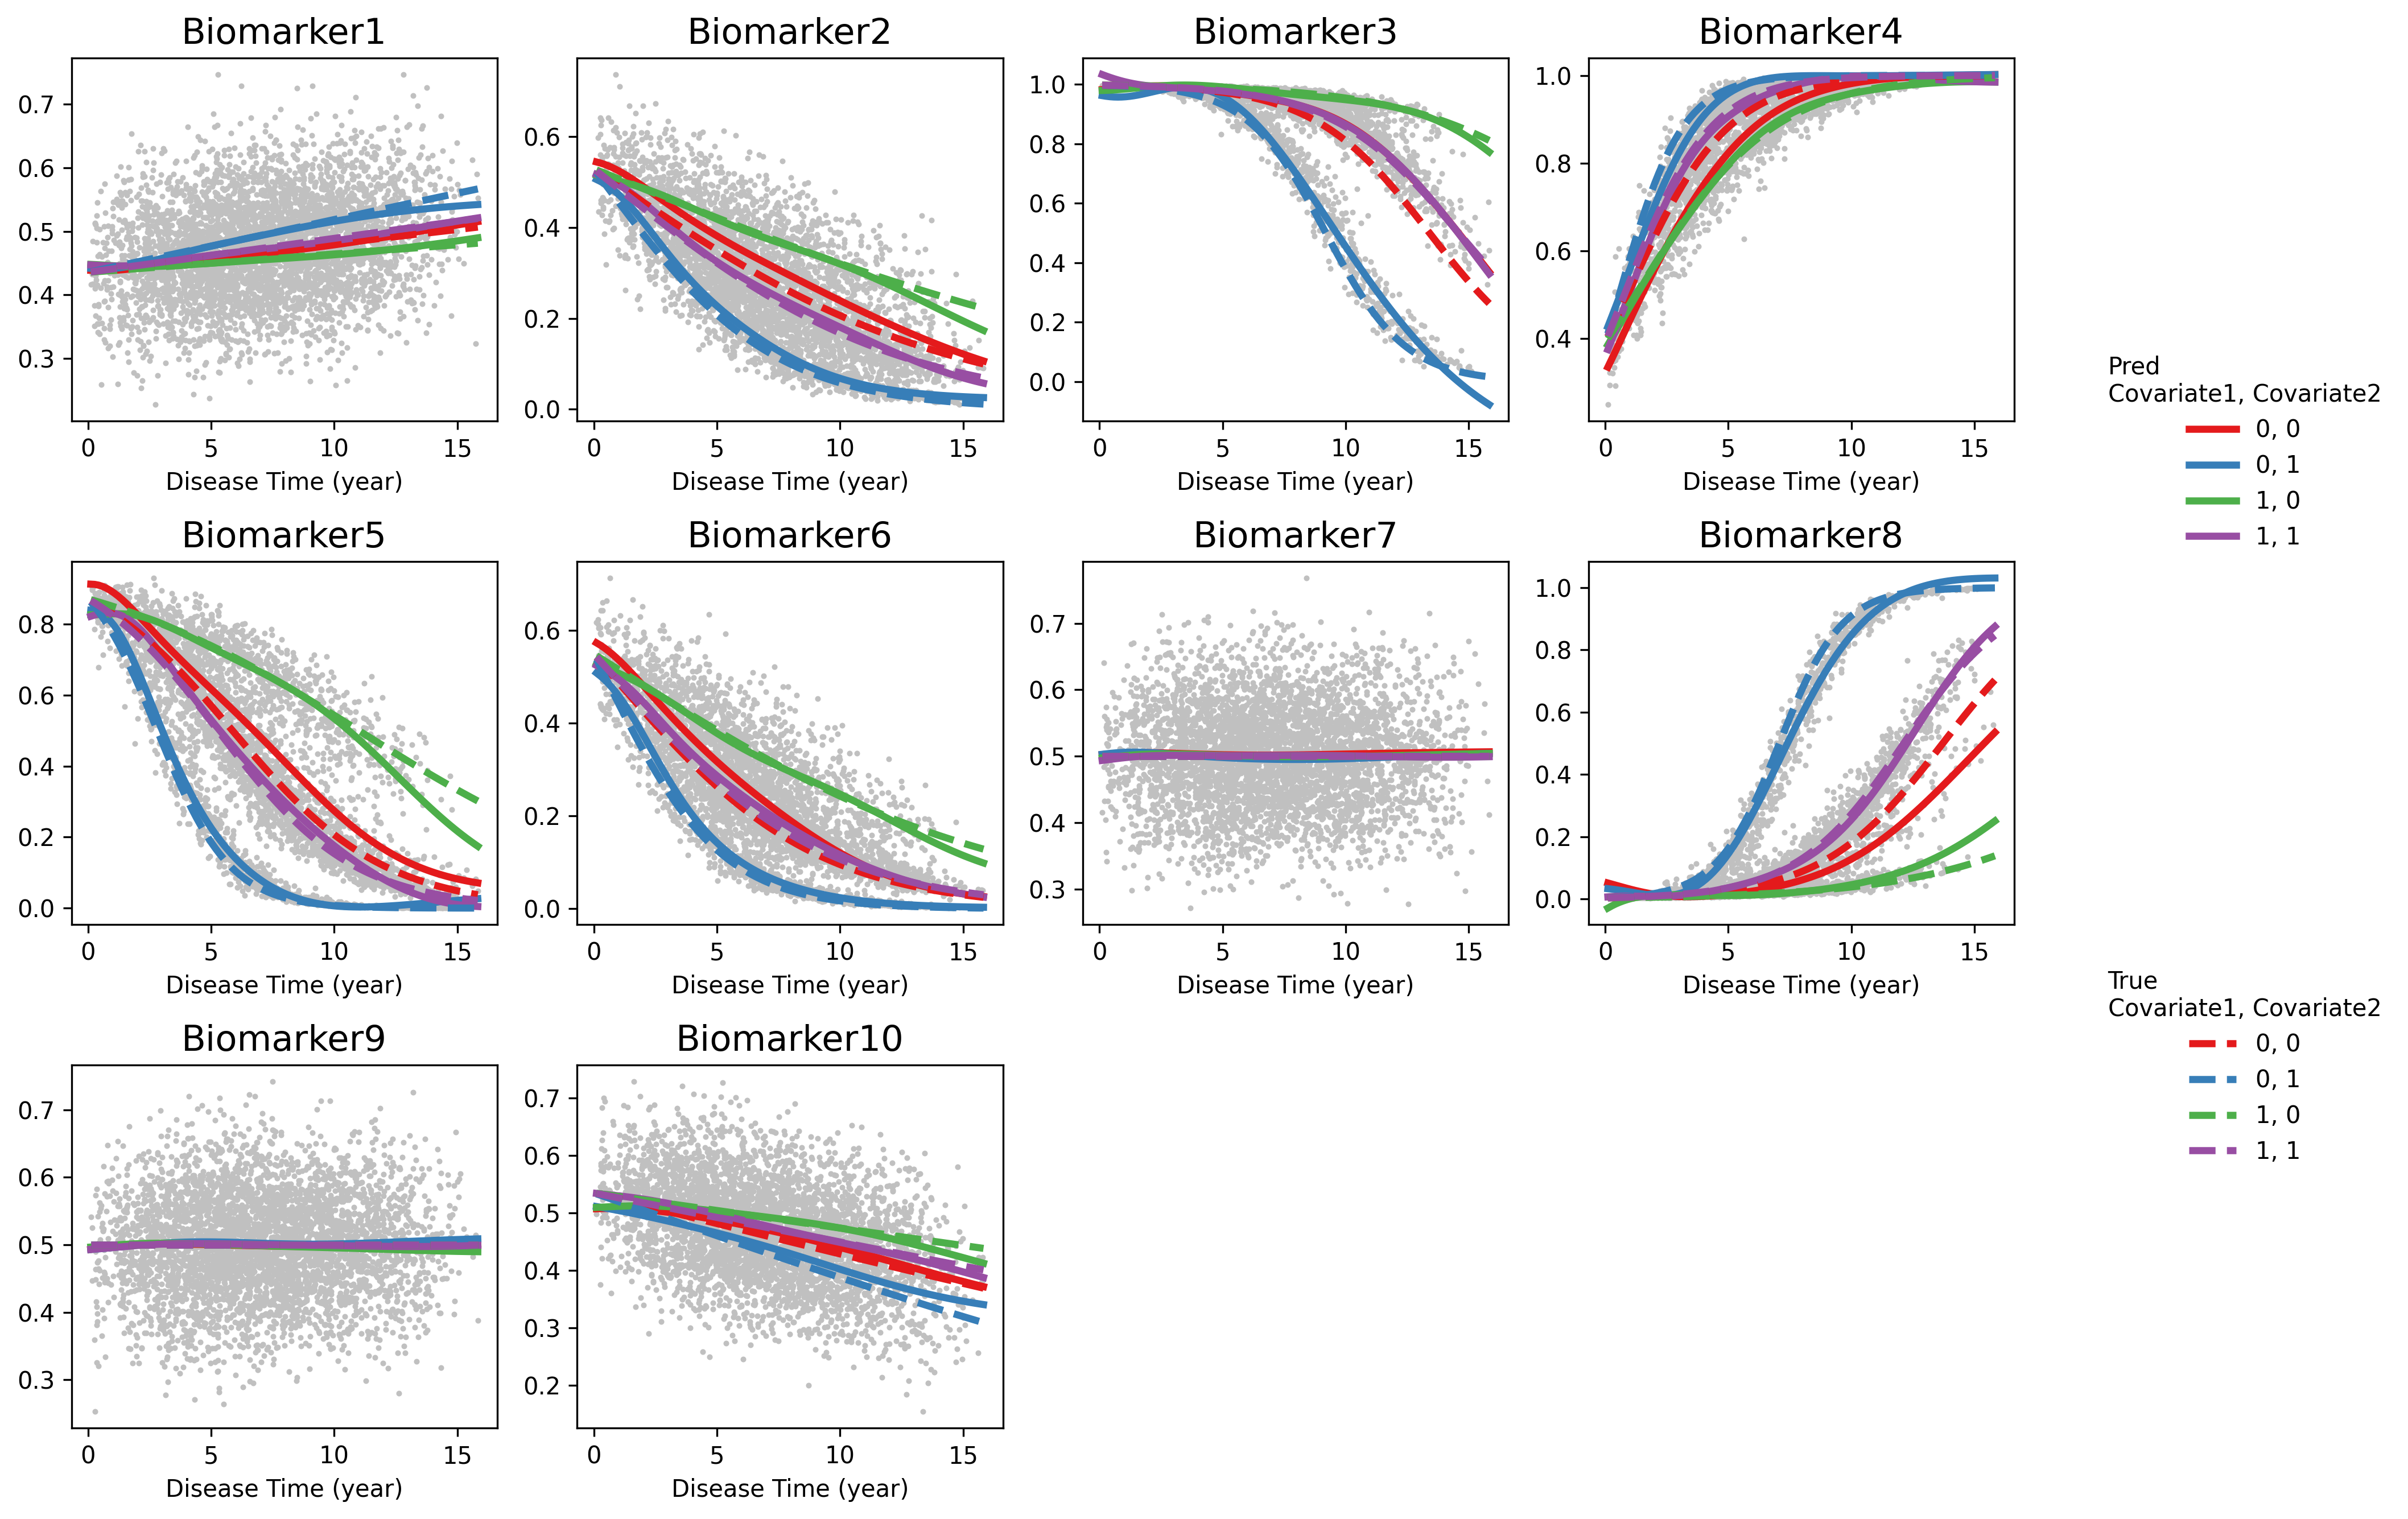

In [13]:
prediction_sim_plot = sreftml.plots.prediction_sim_plot(
    df_test,
    sreft,
    params,
    name_biomarkers,
    name_covariates,
    scaler_cov,
    scaler_y,
)

The figure layout has changed to tight
The label '_nolegend_' of <matplotlib.collections.PathCollection object at 0x0000019137023520> starts with '_'. It is thus excluded from the legend.


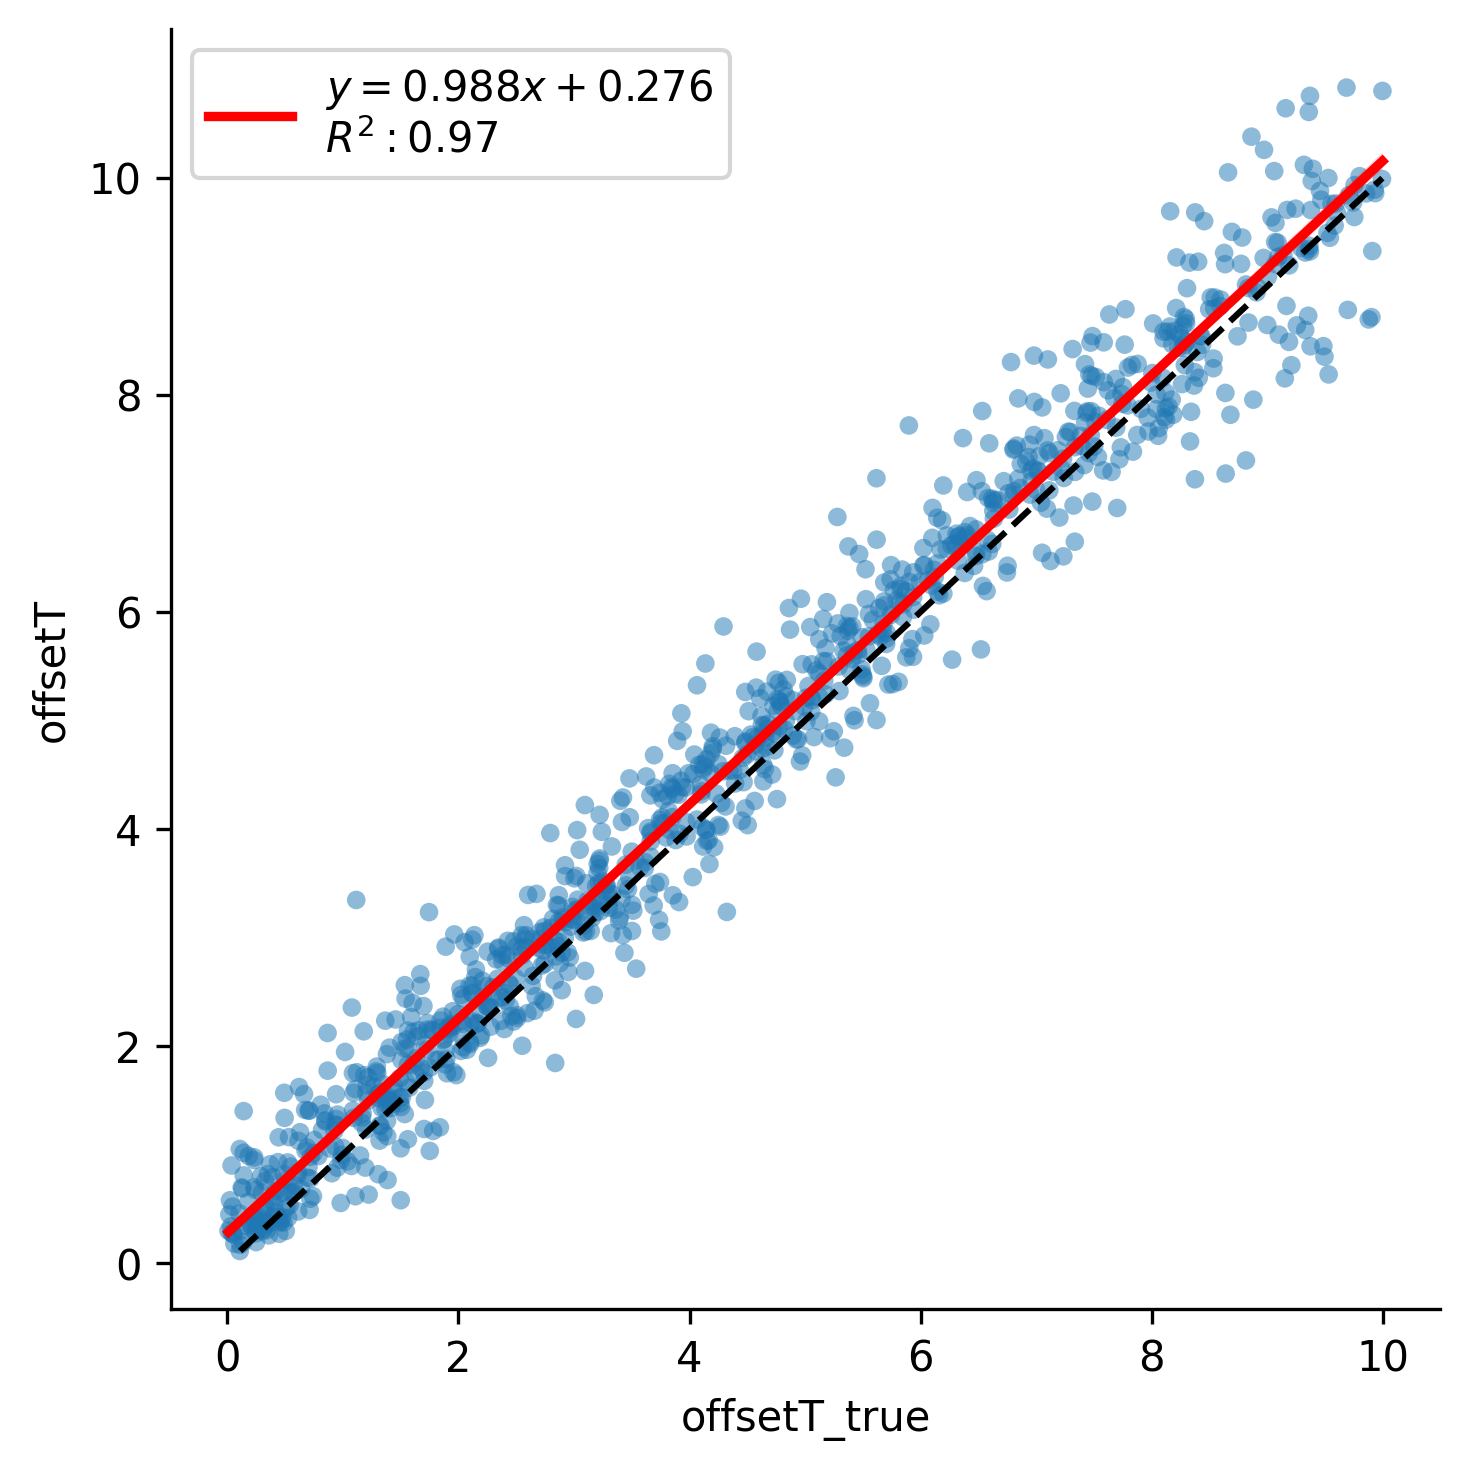

In [14]:
single_panel_scatter_plot = sreftml.plots.single_panel_scatter_plot(
    df_test,
    x_col="offsetT_true",
    y_col="offsetT",
    duplicate_key="ID",
    identity=True,
)

In [15]:
fit_model["gpf"].params_

lambda_    0.012217
c_         0.266079
Name: coef, dtype: float64